In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


# extract the data out
train_data = pd.read_csv('propaganda_train.tsv', sep='\t')
val_data = pd.read_csv('propaganda_val.tsv', sep='\t')

# load datasets seperately
train_texts = train_data['tagged_in_context'].values
train_labels = train_data['label'].values
val_texts = val_data['tagged_in_context'].values
val_labels = val_data['label'].values

# mapping labels
propaganda_label = {"flag_waving": 0,
           "appeal_to_fear_prejudice": 1,
           "causal_oversimplification": 2,
           "doubt": 3,
           "exaggeration,minimisation": 4,
           "loaded_language": 5,
           "name_calling,labeling": 6,
           "repetition": 7, 
           "not_propaganda": 8} 


training_labels = np.array([propaganda_label[i] for i in train_labels])
validation_labels = np.array([propaganda_label[i] for i in val_labels])

In [3]:
# Create BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(propaganda_label))

train_encodings = tokenizer.batch_encode_plus(
    list(train_texts),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

val_encodings = tokenizer.batch_encode_plus(
    list(val_texts),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
# Create Tensor datasets and DataLoader
train_input_ids = train_encodings['input_ids']
train_attention_masks = train_encodings['attention_mask']
train_labels = torch.tensor(training_labels)
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32) 

val_input_ids = val_encodings['input_ids']
val_attention_masks = val_encodings['attention_mask']
val_labels = torch.tensor(validation_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32)



In [5]:
record = []
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks,labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

    # evaluate validation dataset
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            predictions.extend(np.argmax(logits, axis=1))

    val_acc = accuracy_score(val_labels, predictions)
    record.append(val_acc)
    print(f'Epoch {epoch+1}: Validation Accuracy: {val_acc}')

Epoch 1: Validation Accuracy: 0.5344827586206896
Epoch 2: Validation Accuracy: 0.6051724137931035
Epoch 3: Validation Accuracy: 0.6103448275862069
Epoch 4: Validation Accuracy: 0.6551724137931034
Epoch 5: Validation Accuracy: 0.7051724137931035
Epoch 6: Validation Accuracy: 0.7241379310344828
Epoch 7: Validation Accuracy: 0.7327586206896551
Epoch 8: Validation Accuracy: 0.743103448275862
Epoch 9: Validation Accuracy: 0.7637931034482759
Epoch 10: Validation Accuracy: 0.7413793103448276


In [6]:
p_labels = ["flag_waving",
       "appeal_to_fear_prejudice",
       "causal_oversimplification",
       "doubt",
       "exaggeration,minimisation",
       "loaded_language",
       "name_calling,labeling",
       "repetition",
       "not_propaganda"]
       
print(classification_report(val_labels, predictions, target_names=p_labels))

                           precision    recall  f1-score   support

              flag_waving       0.69      0.64      0.67        39
 appeal_to_fear_prejudice       0.65      0.70      0.67        43
causal_oversimplification       0.39      0.61      0.47        31
                    doubt       0.53      0.68      0.60        38
exaggeration,minimisation       0.56      0.54      0.55        28
          loaded_language       0.59      0.51      0.55        37
    name_calling,labeling       0.54      0.71      0.61        31
               repetition       0.33      0.31      0.32        32
           not_propaganda       0.98      0.88      0.92       301

                 accuracy                           0.74       580
                macro avg       0.58      0.62      0.60       580
             weighted avg       0.77      0.74      0.75       580



In [7]:
x_axis=[]
for i in range(0,len(record)):
  x_axis.append(i)

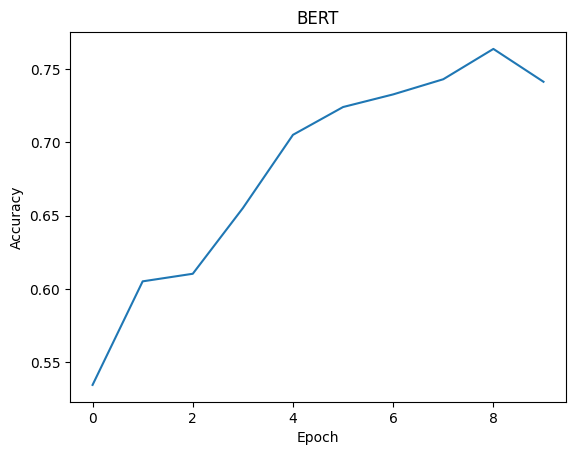

In [9]:
plt.plot(x_axis, record)
plt.title('BERT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()